In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
import spacy 
from spacy.matcher import Matcher
from spacy.tokens import Doc
from spacy.util import filter_spans
import pandas as pd
import re
from collections import Counter
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import copy
from datetime import datetime


print("imported modules")

imported modules


In [5]:
# configuration
start_post = 0
end_post = 42636

In [6]:
# Load csv data
filepath = os.path.join(os.getcwd(), 'QueryResults_sample_42636_14_05_21.csv')

stack_posts = pd.read_csv(filepath, sep = ",")

print("loaded csv data")

loaded csv data


In [7]:
regex_pattern = '(<(pre|code|blockquote|a|strike)(.|\n)*?\/(pre|code|blockquote|a|strike)>)*?|<(p|b|br|br(.|\n)*?\/|sub|sup|em|strong|hr|s|i|ol|ul|li|code)*?>|<\/(p|b|br|sub|sup|em|strong|s|i|ol|ul|li|div|pre|blockquote|a|code)>|<h(.|\n)*?>(.|\n)*?<\/h(.|\n)*?>*?|(<(img|div|ol|ul|li)(.|\n)*?\/*?>)|\n'
def get_date(data_string):
    date = datetime.date(datetime.strptime(data_string, '%Y-%m-%d %H:%M:%S'))
    year = pd.Timestamp(date).year
    quarter = pd.Timestamp(date).quarter
    return year, quarter

def clean_bodys(text):
    text = re.sub(regex_pattern, '', text, flags=re.I)
    text = re.sub('\(|\)', ' ', text, flags=re.I)
    return text

def filter_spans(matches):
    span_list = [doc[match[1]:match[2]] for match in matches]
    filtered_spans = spacy.util.filter_spans(span_list)
    return filtered_spans

In [8]:
def vectorizer_with_threshold(text_vectorizer):
    threshold = 0.5
    vec = [i for i,value in enumerate(text_vectorizer.toarray()[0]) if value >= threshold]
    return vec

def vectorizer_top_n_words(text_vectorizer):    
    n = 3
    vec = np.argsort(text_vectorizer.toarray()).flatten()[::-1][0:n]        
    return vec


def vectorizer_top_n_percent(text_vectorizer, vec_len):
    percent = 0.15    
    n = int(vec_len * percent)
    
    vec = np.argsort(text_vectorizer.toarray()).flatten()[::-1][0:n]            
    return vec

In [9]:
def get_relevant_words(text):
    vectorizer = TfidfVectorizer(stop_words = 'english', min_df = 0.5)
    try:
        text_vectorizer = vectorizer.fit_transform([text])
    except:        
        return False
    relevant_words = []    
    feature_array = np.array(vectorizer.get_feature_names())

    tfidf_bigger_than = vectorizer_with_threshold(text_vectorizer)
    #tfidf_bigger_than = vectorizer_with_n_words(text_vectorizer)
    #tfidf_bigger_than = vectorizer_top_n_percent(text_vectorizer, len(feature_array))
    relevant_words.append(feature_array[tfidf_bigger_than])
    return relevant_words
    
def add_words_to_counter(relevant_words, filtered_spans, year, quarter):    
    for word in relevant_words[0]:
        word_doc = nlp(str(word))      
        for span in filtered_spans:            
            if word_doc[0].lemma_ in span.lemma_:  
                topic_frequency_dict[year][quarter][span.lemma_] += 1                

In [10]:
# clean posts and match words
nlp = spacy.load("en_core_web_lg")
matcher = Matcher(nlp.vocab)

topic_pattern1 = [{'POS': 'ADJ', 'OP': '?'},
           {'OP': '+', 'POS': 'NOUN'},
           {'POS': 'NOUN', 'OP': '?'}
          ]

matcher.add("match_topic1", [topic_pattern1])

word_set = set()
post_df = pd.DataFrame(stack_posts[["QuestionId", "QuestionDate", "QuestionBody", "AnswerId", "AnswerBody", "AnswerDate"]][0:end_post])


# initialize topic frequency counter
topic_frequency_dict = dict()
for year in range(2015, 2022):
    topic_frequency_dict[year] = dict()
    for quarter in range(1, 5):
        topic_frequency_dict[year][quarter] = Counter()
        
for i, line in enumerate(post_df.itertuples()):
    post = pd.DataFrame(line).transpose().drop(0, axis=1)
    post.columns = post_df.columns
    
    # analyze questions    
    if post["QuestionId"][0] != post_df.iloc[i - 1]["QuestionId"]:            
        text = clean_bodys(post["QuestionBody"][0])
        doc = nlp(text)
        matches = matcher(doc)
        
        filtered_spans = filter_spans(matches)
        relevant_words = get_relevant_words(text)
        if relevant_words == False:
            continue
        
        year, quarter = get_date(post["QuestionDate"][0])
        add_words_to_counter(relevant_words, filtered_spans, year, quarter)        
    
    # analyze answers
    text = clean_bodys(post["AnswerBody"][0])      
    doc = nlp(text)        
    matches = matcher(doc)
    
    filtered_spans = filter_spans(matches)    
    relevant_words = get_relevant_words(text)
    if relevant_words == False:
        continue
    
    year, quarter = get_date(post["AnswerDate"][0])   
    add_words_to_counter(relevant_words, filtered_spans, year, quarter)
    
print("finished")

finished


In [144]:
def get_x_y_values(topic):    
    y_values = []    
    for year in topic_frequency_dict:    
        for quarter in topic_frequency_dict[year]:
            if year == 2021 and quarter == 2:
                break
            y_values.append(topic_frequency_dict[year][quarter][topic])            
    return y_values

In [171]:
y_label_amount = 5
fontsize = 15
yticks_multiplicator = 100
fig_x_size = 6.5
fig_y_size = 5
fig_alpha = 0.4
ax_alpha = 0.5
marker_size = 5
line_color = '#F48024'
face_color = '#BCBBBB'

def draw_plot(y_values):
    fig, ax = plt.subplots(figsize=(fig_x_size,fig_y_size))
    fig.patch.set_facecolor('#BCBBBB')
    fig.patch.set_alpha(ax_alpha)

    plt.suptitle('Themenfrequenz ' + topic, fontsize=fontsize + 2)
    plt.xlabel('Quartale', fontsize=fontsize)
    plt.ylabel('Häufigkeit', fontsize=fontsize)        
    ax.patch.set_facecolor(face_color)
    ax.patch.set_alpha(ax_alpha)

    ax.plot([x_values for x_values in range(0, 25)], y_values, color=line_color, marker='o', markersize=marker_size)
    
    quarters = [x * 4 for x in range(2021-2015)]
    quarters.append(24)
    years = [year for year in range(2015, 2022)]
    
    plt.xticks(quarters, years)
    plt.yticks([y * yticks_multiplicator for y in range(0,y_label_amount)])
    plt.style.use('bmh')
    plt.show()

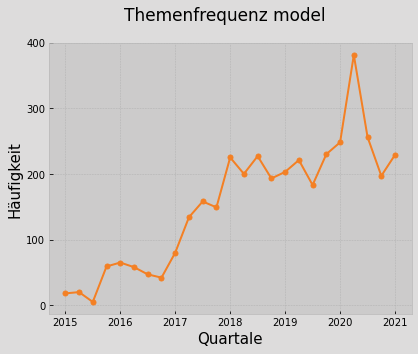

In [172]:
topic = "model"

y_values = get_x_y_values(topic)
draw_plot(y_values)


[0, 4, 8, 12, 16, 20, 24]
[2015, 2016, 2017, 2018, 2019, 2020, 2021]


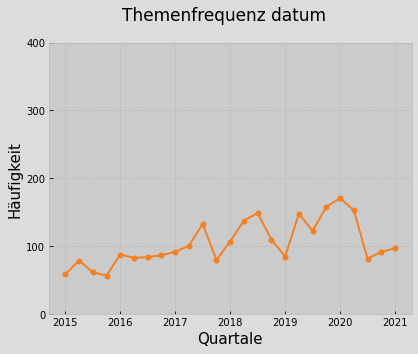

In [160]:
topic = "datum"

y_values = get_x_y_values(topic)
draw_plot(y_values)

[0, 4, 8, 12, 16, 20, 24]
[2015, 2016, 2017, 2018, 2019, 2020, 2021]


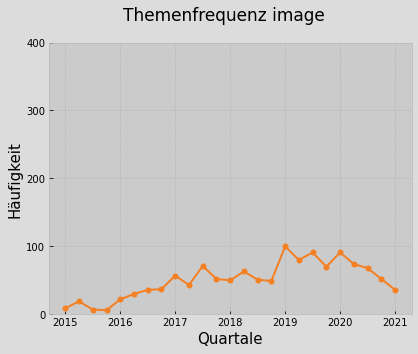

In [161]:
topic = "image"

y_values = get_x_y_values(topic)
draw_plot(y_values)

[0, 4, 8, 12, 16, 20, 24]
[2015, 2016, 2017, 2018, 2019, 2020, 2021]


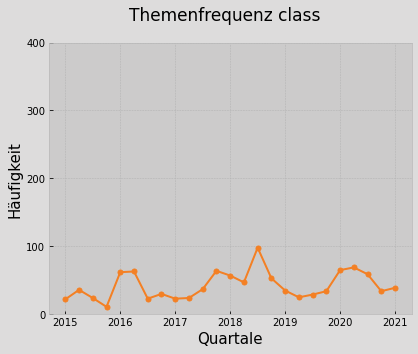

In [162]:
topic = "class"

y_values = get_x_y_values(topic)
draw_plot(y_values)

[0, 4, 8, 12, 16, 20, 24]
[2015, 2016, 2017, 2018, 2019, 2020, 2021]


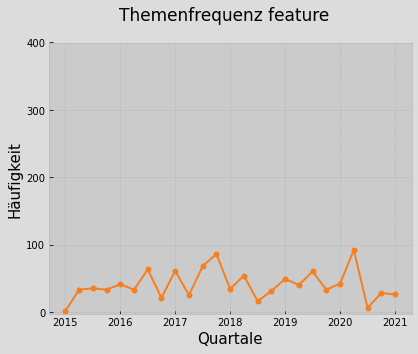

In [163]:
topic = "feature"

y_values = get_x_y_values(topic)
draw_plot(y_values)

[0, 4, 8, 12, 16, 20, 24]
[2015, 2016, 2017, 2018, 2019, 2020, 2021]


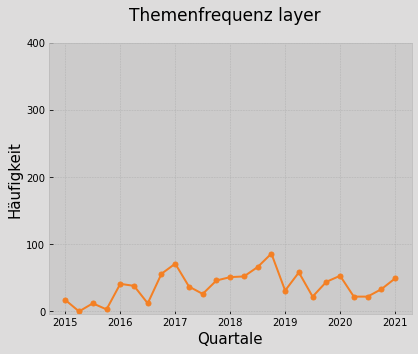

In [164]:
topic = "layer"

y_values = get_x_y_values(topic)
draw_plot(y_values)

[0, 4, 8, 12, 16, 20, 24]
[2015, 2016, 2017, 2018, 2019, 2020, 2021]


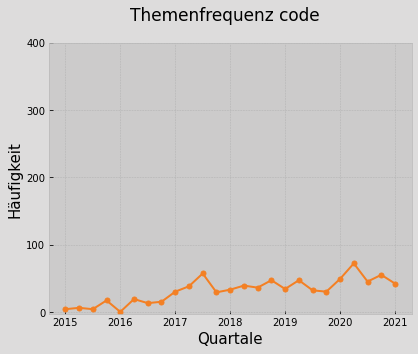

In [165]:
topic = "code"

y_values = get_x_y_values(topic)
draw_plot(y_values)

[0, 4, 8, 12, 16, 20, 24]
[2015, 2016, 2017, 2018, 2019, 2020, 2021]


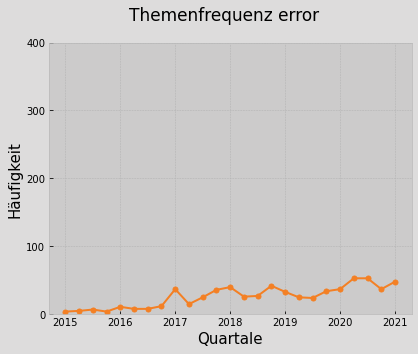

In [166]:
topic = "error"

y_values = get_x_y_values(topic)
draw_plot(y_values)

[0, 4, 8, 12, 16, 20, 24]
[2015, 2016, 2017, 2018, 2019, 2020, 2021]


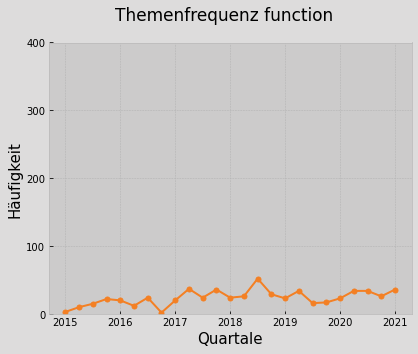

In [167]:
topic = "function"

y_values = get_x_y_values(topic)
draw_plot(y_values)

[0, 4, 8, 12, 16, 20, 24]
[2015, 2016, 2017, 2018, 2019, 2020, 2021]


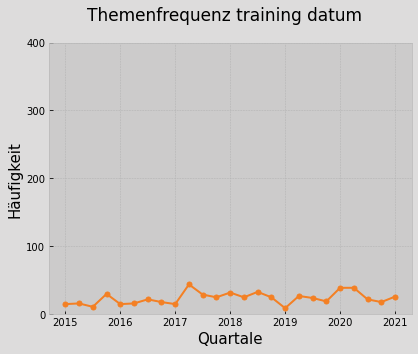

In [168]:
topic = "training datum"

y_values = get_x_y_values(topic)
draw_plot(y_values)

In [ ]:
topic_frequency_df = pd.DataFrame.from_dict(topic_frequency_dict).transpose()
topic_counter = Counter()

for year in topic_frequency_df:
    for quarter in topic_frequency_df[year]:
        topic_counter = sum((topic_counter, quarter), Counter())
topic_counter